In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import OrderedDict
import scipy.optimize 
import mpl_toolkits.axisartist as axisartist
import os
import math
import cmath
import scipy.optimize as opt
import random
import operator
import copy
import sys
import scipy.integrate as integrate
import scipy.sparse as sp
from scipy import stats
from numpy.linalg import inv
from scipy import sparse
from timeit import default_timer as timer
from scipy.integrate import dblquad
import numba
from numba import jit
import pylab as pl
from matplotlib import rc

rc('text', usetex=True)
rc('text.latex', preamble=r"\usepackage{braket} \usepackage{color}")
mpl.rc('font',family='DejaVu Sans')

## 1D Evolution of initial wave function in some static potential V(x):

We consider 1D time-dependent Schrödinger equation 

$i \hbar \, \partial_t \psi(x,t)=-\frac{1}{2m} \partial_x^2\psi(x,t)+V(x)\psi(x,t)$,

where $\psi$ is a normalized wave-function of the system and $V(x)$ denotes the static potential in 1D. For simplicity we consider units where $\hbar=m=1$. The system size is $L=1$ and we will consider both periodic (PBC) and open (OBC) boundary conditions.

To numerically evolve the system we employ the Crank–Nicolson finite difference method

$\partial_t u(x,t)=F(u,x,t,\partial_x u, \partial_x^2 u) \longrightarrow \frac{1}{\delta t}(u_i^{n+1}-u_i^n)=\frac{1}{2}\left[F_i^{n+1}+F_{i}^{n}\right]$,

where $(x,t)\rightarrow(x_0 + i \delta x, t_0 + n\delta t)$ with $i,n=0,1,2,\ldots$. Here we introduced the shorthand notation $u_i^n=u(x_0+i\delta x, t_0 + n\delta t)$ and similarly for $F$.  

In our problem we have second order derivative that can be discretized as follows ($x_i=x_0+i\delta x, \, t_n=t_0+n \delta t$)

$\partial_x^2 \psi(x_i,t_n) \longrightarrow \frac{1}{(\delta t)^2}(\psi_{i+1}^{n}-2\psi_i^n+ \psi_{i-1}^{n})$.

In consequence, by the Crank-Nicolson scheme we have

$\frac{i}{\delta t}(\psi_i^{n+1}-\psi_i^n) = \frac{1}{4(\delta t)^2} (\psi_{i+1}^{n}-2\psi_i^n+ \psi_{i-1}^{n})+ \frac{1}{4(\delta t)^2} (\psi_{i+1}^{n+1}-2\psi_i^{n+1}+ \psi_{i-1}^{n+1}) +\frac{1}{2}V_i(\psi_i^{n}+\psi_i^{n+1})$.

Let us introduce the matrix $\mathbb{D_2}$ corresponding to the second derivative and vector od $\psi$'s at a given $t$

$\mathbb{D_2}=\left(
\begin{array}{ccccccccc}
-2 & 1 & 0 & 0 & \ldots & 0 & b\\
1 & -2 & 1 & 0&  0 & \ldots & 0 \\
0 & 1 & -2 & 1 & 0 &\ldots  &  0 \\
&&&\ldots &&&  \\
0 & \ldots  & 0 & 1 & -2 & 1 & 0\\
0 & \ldots & 0 & 0 & 1 & -2 & 1\\
b & 0 & \ldots & 0 & 0 & 1 & -2
\end{array}
\right)
\qquad \& \qquad
\Psi^n=\left(
\begin{array}{ccc}
\psi_0^n \\
\psi_1^n \\ 
\psi_2^n \\
\psi_3^n \\
.\\
.\\
.
\end{array}
\right),
\qquad \mathrm{where} \quad
b=\left\{\begin{array}{lll}
1 & \mathrm{for} & \mathrm{PBC} \\ 
0 & \mathrm{for} & \mathrm{OBC}
\end{array}\right.
.
$

By a simple reorganization of terms and introducing $\mathbb{O}_\pm=\frac{i}{\delta t}\mathbb{1}\pm\frac{1}{4 (\delta t)^2}\mathbb{D_2}\mp\frac{1}{2}\mathrm{diag}(V_0,V_1, V_2, \ldots)$ we immediately find

$\Psi^{n+1}=\mathbb{O}_+^{-1} \mathbb{O}_-\Psi^n$

In [6]:
# define matrices O_+^-1 and O_-:
def InvOplus(vecV, dx, dt, b): # b = 0 or 1 for OBC and PBC respectively
    N = len(vecV)
    A = 1./(4*dx*dx)
    diag = np.ones([N])*A
    mat = sp.spdiags([diag*b, diag,(1j/dt-2*diag-vecV/2.) ,diag, diag*b],[-N+1,-1,0,1,N-1],N,N)
    M0 = np.array(mat.toarray(),dtype = np.complex128)
    return inv(M0)

def Ominus(vecV, dx, dt, b): # b = 0 or 1 for OBC and PBC respectively
    N = len(vecV)
    A = 1./(4*dx*dx)
    diag = -np.ones([N])*A
    mat = sp.spdiags([diag*b, diag,(1j/dt-2*diag+vecV/2.) ,diag, diag*b],[-N+1,-1,0,1,N-1],N,N)
    return mat

# D2 matrix
def D2(N,b):
    diag = np.ones([N])
    mat = sp.spdiags([diag*b, diag,-2*diag ,diag, diag*b],[-N+1,-1,0,1,N-1],N,N) 
    return mat

# calculate energy and norm of the state to track stability of the evolution in case of quadratic nonlinearity
def energy_norm(psi, vecV, D2mat, dx):
    ddxpsi = D2mat.dot(psi)/(dx**2)
    K = -0.5*np.conjugate(psi)*ddxpsi
    U = vecV*np.absolute(psi)**2
    return [np.sum(K+U)*dx, np.sum(np.absolute(psi)**2)*dx]
    
def evolution(IOp, Om, Nsaves, Nsteps, psi, vecV, dx, dt, b):
      
    M = len(vecV)
    D2mat = D2(M,b)
    
    states = np.zeros((Nsaves+1,M),dtype=np.complex128)
    ens = np.zeros((Nsaves+1),dtype=np.complex128)
    nrs = np.zeros((Nsaves+1))

    states[0] = psi
    Tab_e_n = energy_norm(psi, vecV, D2mat, dx)
    ens[0] = Tab_e_n[0]
    nrs[0] = Tab_e_n[1]

    r = int(np.floor(Nsaves/10))
    if Nsaves<10:
        r = 1
    for s in range(0,Nsaves):
        for j in range(0,Nsteps):
            psi = IOp.dot( Om.dot(psi) )
        
        states[s+1] = psi
        Tab_e_n  = energy_norm(psi, vecV, D2mat, dx)
        ens[s+1] = Tab_e_n[0]
        nrs[s+1] = Tab_e_n[1]
        if s%r == 0:
            print(
                  "time = "+str(np.round((s+1)*Nsteps*dt,5) ) 
                    +" , energy = " +str(np.round(ens[s+1],8) ) 
                    + " , norm = " +str(np.round(nrs[s+1],8) )
                 )
    return [states, ens, nrs]

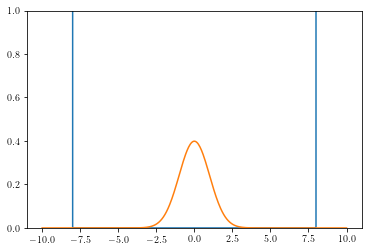

In [7]:
L = 20
M = 400
X = np.linspace(-L/2,L/2,M)
dx = X[1]-X[0]
dt = 0.0001
b=0

# define potential - two high walls close to the system boundaries
vecV = 50*( (np.tanh((X-8)/0.001)+1)-(np.tanh((X+8)/0.001)-1) )

# set initial state with a gaussian-shape density
mu = 0
std = 1
snd = stats.norm(mu, std)

plt.plot(X,vecV);
plt.plot(X, snd.pdf(X))
plt.ylim((0,1));
plt.show()

In [8]:
# set the state in a motion with velocity v
v=5
psi =  np.sqrt(snd.pdf(X))*np.exp(1j*v*X)

# generate matrices
IOp = InvOplus(vecV, dx, dt, b)
Om  = Ominus(vecV, dx, dt, b)

Nsteps = 375
Nsaves= 400
W = evolution(IOp, Om, Nsaves, Nsteps, psi, vecV, dx, dt, b)

time = 0.0375 , energy = (12.55578157+0j) , norm = 1.0
time = 1.5375 , energy = (12.55578157-0j) , norm = 1.0
time = 3.0375 , energy = (12.55578157-0j) , norm = 1.0
time = 4.5375 , energy = (12.55578157+0j) , norm = 1.0
time = 6.0375 , energy = (12.55578157-0j) , norm = 1.0
time = 7.5375 , energy = (12.55578157-0j) , norm = 1.0
time = 9.0375 , energy = (12.55578157+0j) , norm = 1.0
time = 10.5375 , energy = (12.55578157+0j) , norm = 1.0
time = 12.0375 , energy = (12.55578157-0j) , norm = 1.0
time = 13.5375 , energy = (12.55578157-0j) , norm = 1.0


In [89]:
# Enable interactive plot
#%matplotlib notebook

#from matplotlib import animation

#fig, ax = plt.subplots()
#line, = ax.plot([])
#ax.set_xlim(-L/2,L/2);
#ax.set_ylim(0, 0.8);
#ax.plot(X,vecV,color='black');
#plt.xlabel("position",size=15);
#plt.xticks(size=15);
#plt.yticks(size=15);

#def animate(frame_num):
#    Y = np.absolute( W[0][frame_num] )**2
#    line.set_data((X, Y))
#    ax.legend([r"$|\psi|^2$"+" at time = " + str( round( frame_num*dt*Nsteps,1))],fontsize=20);
#    return line

#anim = animation.FuncAnimation(fig, animate, frames=len(W[0]), interval=60)
#plt.show()

#from IPython.display import HTML
#HTML(anim.to_jshtml())
#HTML(anim.to_html5_video())

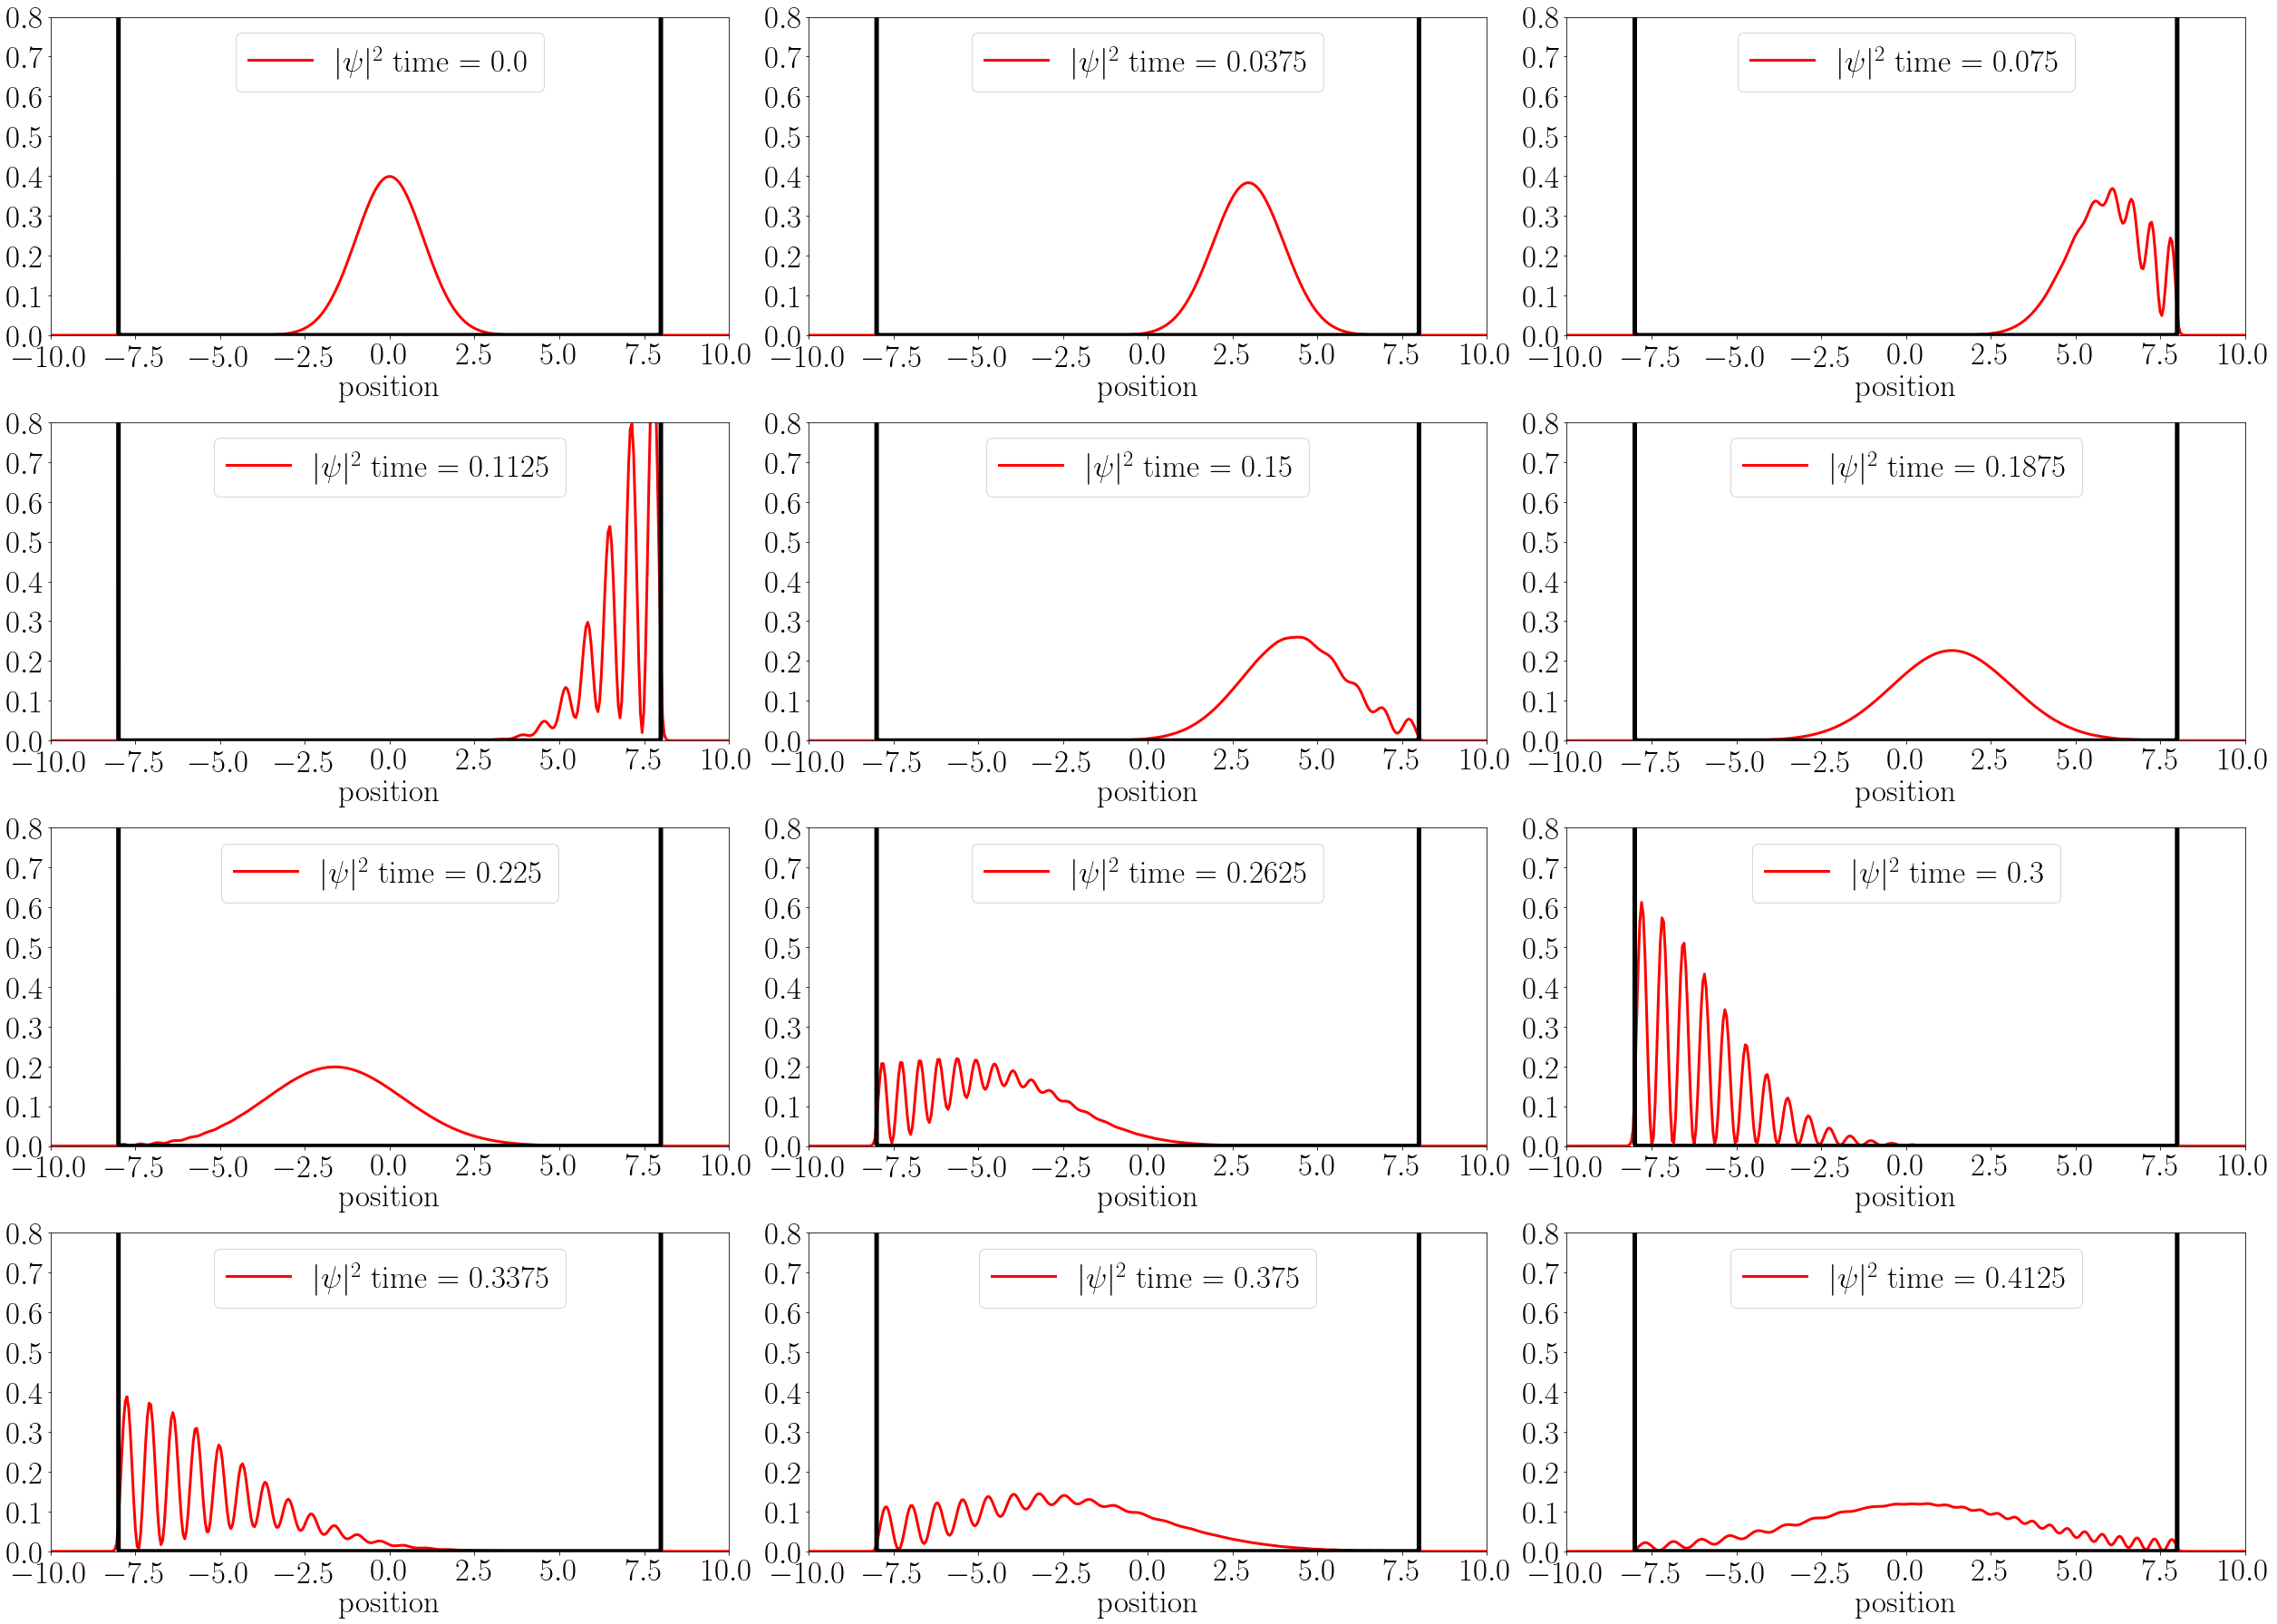

In [9]:
rr = int(len(W[0])/24)
for q in range(0,12):
    plt.subplot(4,3,q+1)
    plt.ylim((0,0.8));
    plt.xlim((-L/2,L/2));
    Y = np.absolute( W[0][rr*q] )**2
    plt.plot(X,Y, color='red', linewidth=3)
    plt.xlabel("position",size=35);
    plt.xticks(size=35);
    plt.yticks(size=35);
    plt.legend([r"$|\psi|^2$"+" time = " + str( round( q*dt*Nsteps,4))],fontsize=35);
    plt.plot(X,vecV,color='black',linewidth=5);
    fig = mpl.pyplot.gcf()
    fig.set_size_inches(35, 25)
plt.tight_layout()

as expected one can see the spreading gaussian wave packet bouncing between the walls.

## Include nonlinearity

We can extend the model by adding a nonlinearity $\mathcal{N}$:

$i \hbar \, \partial_t \psi(x,t)=-\frac{1}{2m} \partial_x^2\psi(x,t)+V(x)\psi(x,t)+\mathcal{N}(\psi(x,t))$,

In such a case having $\mathcal{N}(\psi(x_i,t_n))=\mathcal{N}_i^n$ we do not know $\mathcal{N}_i^{n+1}$ that is required in the Crank-Nicolson iteration, i.e.,

$\frac{i}{\delta t}(\psi_i^{n+1}-\psi_i^n) = \frac{1}{4(\delta t)^2}[\mathbb{D}_2 \Psi^{n+1}]_i + \frac{1}{4(\delta t)^2}[\mathbb{D}_2 \Psi^{n}]_i +\frac{1}{2}V_i(\psi_i^{n+1}+\psi_i^{n})+\frac{1}{2}(\mathcal{N}_i^{n+1}+\mathcal{N}_i^{n})$.


One can overcome this issue by employing a linear extrapolation $\mathcal{N}_i^{n+1} \approx \mathcal{N}_i^{n}+\left(\mathcal{N}_i^n- \mathcal{N}_i^{n-1}\right)= 2\mathcal{N}_i^{n}-\mathcal{N}_i^{n-1}$. Therefore, one obtains

$\Psi^{n+1}=\mathbb{O}_+^{-1} [\mathbb{O}_-\Psi^n+ \Gamma^n] \qquad \mathrm{where} \qquad \Gamma^n = \frac{1}{2}\left(3\mathcal{N}_i^{n}-\mathcal{N}_i^{n-1}\right)$.

### Gross-Pitaevskii equation

Let us consider $\mathcal{N}(\psi(x,t))= g |\psi(x,t)|^2 \psi(x,t)$ that appear in the Gross-Pitaevskii equation

$i \hbar \, \partial_t \psi(x,t)=-\frac{1}{2m} \partial_x^2\psi(x,t)+V(x)\psi(x,t)+g |\psi(x,t)|^2 \psi(x,t)$.

This equation possesses dark and bright soliton solutions where the later one appears in the ground state for negative and strong enough interparticle interactions measured by $g$. 

### Imaginary time evolution

In quantum mechanics one can expand $\psi(x,t)$ in the basis of energy eigenstates, i.e, 

$\psi(x,t)=\sum_{j}\mathrm{e}^{-\frac{i}{\hbar} E_j t} \phi_j(x) \qquad \mathrm{where} \qquad \hat{H}_j\phi(x)=E_j\phi_j(x) \qquad \mathrm{and} \qquad \phi_j(x,t)=\mathrm{e}^{-\frac{i}{\hbar} E_j t} \phi_j(x)$.

When switching to imaginary time $\tau=-it$ we immediately see that 

$\psi(x,t)\longrightarrow \psi(x,\tau) = \sum_{j}\mathrm{e}^{-\frac{1}{\hbar} E_j \tau} \phi_j(x) \stackrel{\tau\rightarrow \infty}{\longrightarrow}\phi_g(x) \quad \text{where } \phi_g(x) \text{ is the lowest energy state corresponding to } E_g<E_{j\neq g}$.

Note that the imaginary time evolution does not conserve the norm! Therefore, the state $\psi$ should be normalized after each iteration.

### Numerical experiment

First, by employing the imaginary time evolution I will find bright soliton states for different $g$ and choose two significantly narrower than the double well potential considered above. Second I set this solitons in motion with some velocity and simulate their nonlinear dynamics.

In [10]:
# D2 matrix
def D2(N,b):
    diag = np.ones([N])
    mat = sp.spdiags([diag*b, diag,-2*diag ,diag, diag*b],[-N+1,-1,0,1,N-1],N,N) 
    return mat

# calculate energy and norm of the state to track stability of the evolution in case of quadratic nonlinearity
def energy_norm2(psi, vecV, D2mat, dx, g):
    ddxpsi = D2mat.dot(psi)/(dx**2)
    K = -0.5*np.conjugate(psi)*ddxpsi
    U = vecV*np.absolute(psi)**2+ g/2.*np.absolute(psi)**4
    return [np.sum(K+U)*dx, np.sum(np.absolute(psi)**2)*dx]
    
# evolution in case of quadratic nonlinearity
def evolution2(IOp, Om, Nsaves, Nsteps, psi, vecV, dx, dt, g, b):
      
    M = len(vecV)
    D2mat = D2(M,b)
    
    states = np.zeros((Nsaves+1,M),dtype=np.complex128)
    ens = np.zeros((Nsaves+1),dtype=np.complex128)
    nrs = np.zeros((Nsaves+1))

    states[0] = psi
    Tab_e_n = energy_norm2(psi, vecV, D2mat, dx, g)
    ens[0] = Tab_e_n[0]
    nrs[0] = Tab_e_n[1]
    
    # initial nonlinearity (assume that "n = n-1")
    nonl0 = g* np.absolute(psi)**2 *psi
    nonl1 = g* np.absolute(psi)**2 *psi
    Gamma = 0.5*(3*nonl1 -nonl0)

    r = int(np.floor(Nsaves/10))
    if Nsaves<10:
        r = 1
    for s in range(0,Nsaves):
        for j in range(0,Nsteps):
            
            nonl0 = g* np.absolute(psi)**2 *psi
            
            psi = IOp.dot( Om.dot(psi) + Gamma )
            #normalization
            SumPsi2 = np.sum(np.absolute(psi)**2)*dx
            psi = psi/np.sqrt(SumPsi2)
            
            nonl1 = g* np.absolute(psi)**2 *psi
            Gamma = 0.5*(3*nonl1 -nonl0)
        
        states[s+1] = psi
        Tab_e_n  = energy_norm2(psi, vecV, D2mat, dx, g)
        ens[s+1] = Tab_e_n[0]
        nrs[s+1] = Tab_e_n[1]
        if s%r == 0:
            print(
                  "time = "+str(np.round((s+1)*Nsteps*dt,5) ) 
                    +" , energy = " +str(np.round(ens[s+1],8) ) 
                    + " , norm = " +str(np.round(nrs[s+1],8) )
                 )
    return [states, ens, nrs]

In [12]:
L = 20
M = 400
X = np.linspace(-L/2,L/2,M)
dx = X[1]-X[0]
b=0

# define potential 
50*( (np.tanh((X-8)/0.001)+1)-(np.tanh((X+8)/0.001)-1) )

# set initial state for imaginary time evolution as a gaussian
mu = 0
std = 2
snd = stats.norm(mu, std)
psi =  np.sqrt(snd.pdf(X))

# imaginary time
dt = -1j*0.0005
# interaction strength
Tab_g = np.linspace(0,-2.5,6)

# generate matrices
IOp = InvOplus(vecV, dx, dt, b)
Om  = Ominus(vecV, dx, dt, b)

Ws=[]
    
Nsteps = 20000
Nsaves = 5 

for j in range(0, len(Tab_g)):

    print("\nimaginary time evolution for g = ", Tab_g[j],)
    W = evolution2(IOp, Om, Nsaves, Nsteps, psi, vecV, dx, dt, Tab_g[j], b)
    Ws.append(W)


imaginary time evolution for g =  0.0
time = -10j , energy = (0.0194793+0j) , norm = 1.0
time = -20j , energy = (0.01885857+0j) , norm = 1.0
time = -30j , energy = (0.0188279+0j) , norm = 1.0
time = -40j , energy = (0.01882639+0j) , norm = 1.0
time = -50j , energy = (0.01882632+0j) , norm = 1.0

imaginary time evolution for g =  -0.5
time = -10j , energy = (-0.0063803+0j) , norm = 1.0
time = -20j , energy = (-0.00658235+0j) , norm = 1.0
time = -30j , energy = (-0.00660188+0j) , norm = 1.0
time = -40j , energy = (-0.00660382+0j) , norm = 1.0
time = -50j , energy = (-0.00660402+0j) , norm = 1.0

imaginary time evolution for g =  -1.0
time = -10j , energy = (-0.04125803+0j) , norm = 1.0
time = -20j , energy = (-0.04136392+0j) , norm = 1.0
time = -30j , energy = (-0.04137159+0j) , norm = 1.0
time = -40j , energy = (-0.04137212+0j) , norm = 1.0
time = -50j , energy = (-0.04137215+0j) , norm = 1.0

imaginary time evolution for g =  -1.5
time = -10j , energy = (-0.09309867+0j) , norm = 1.0
t

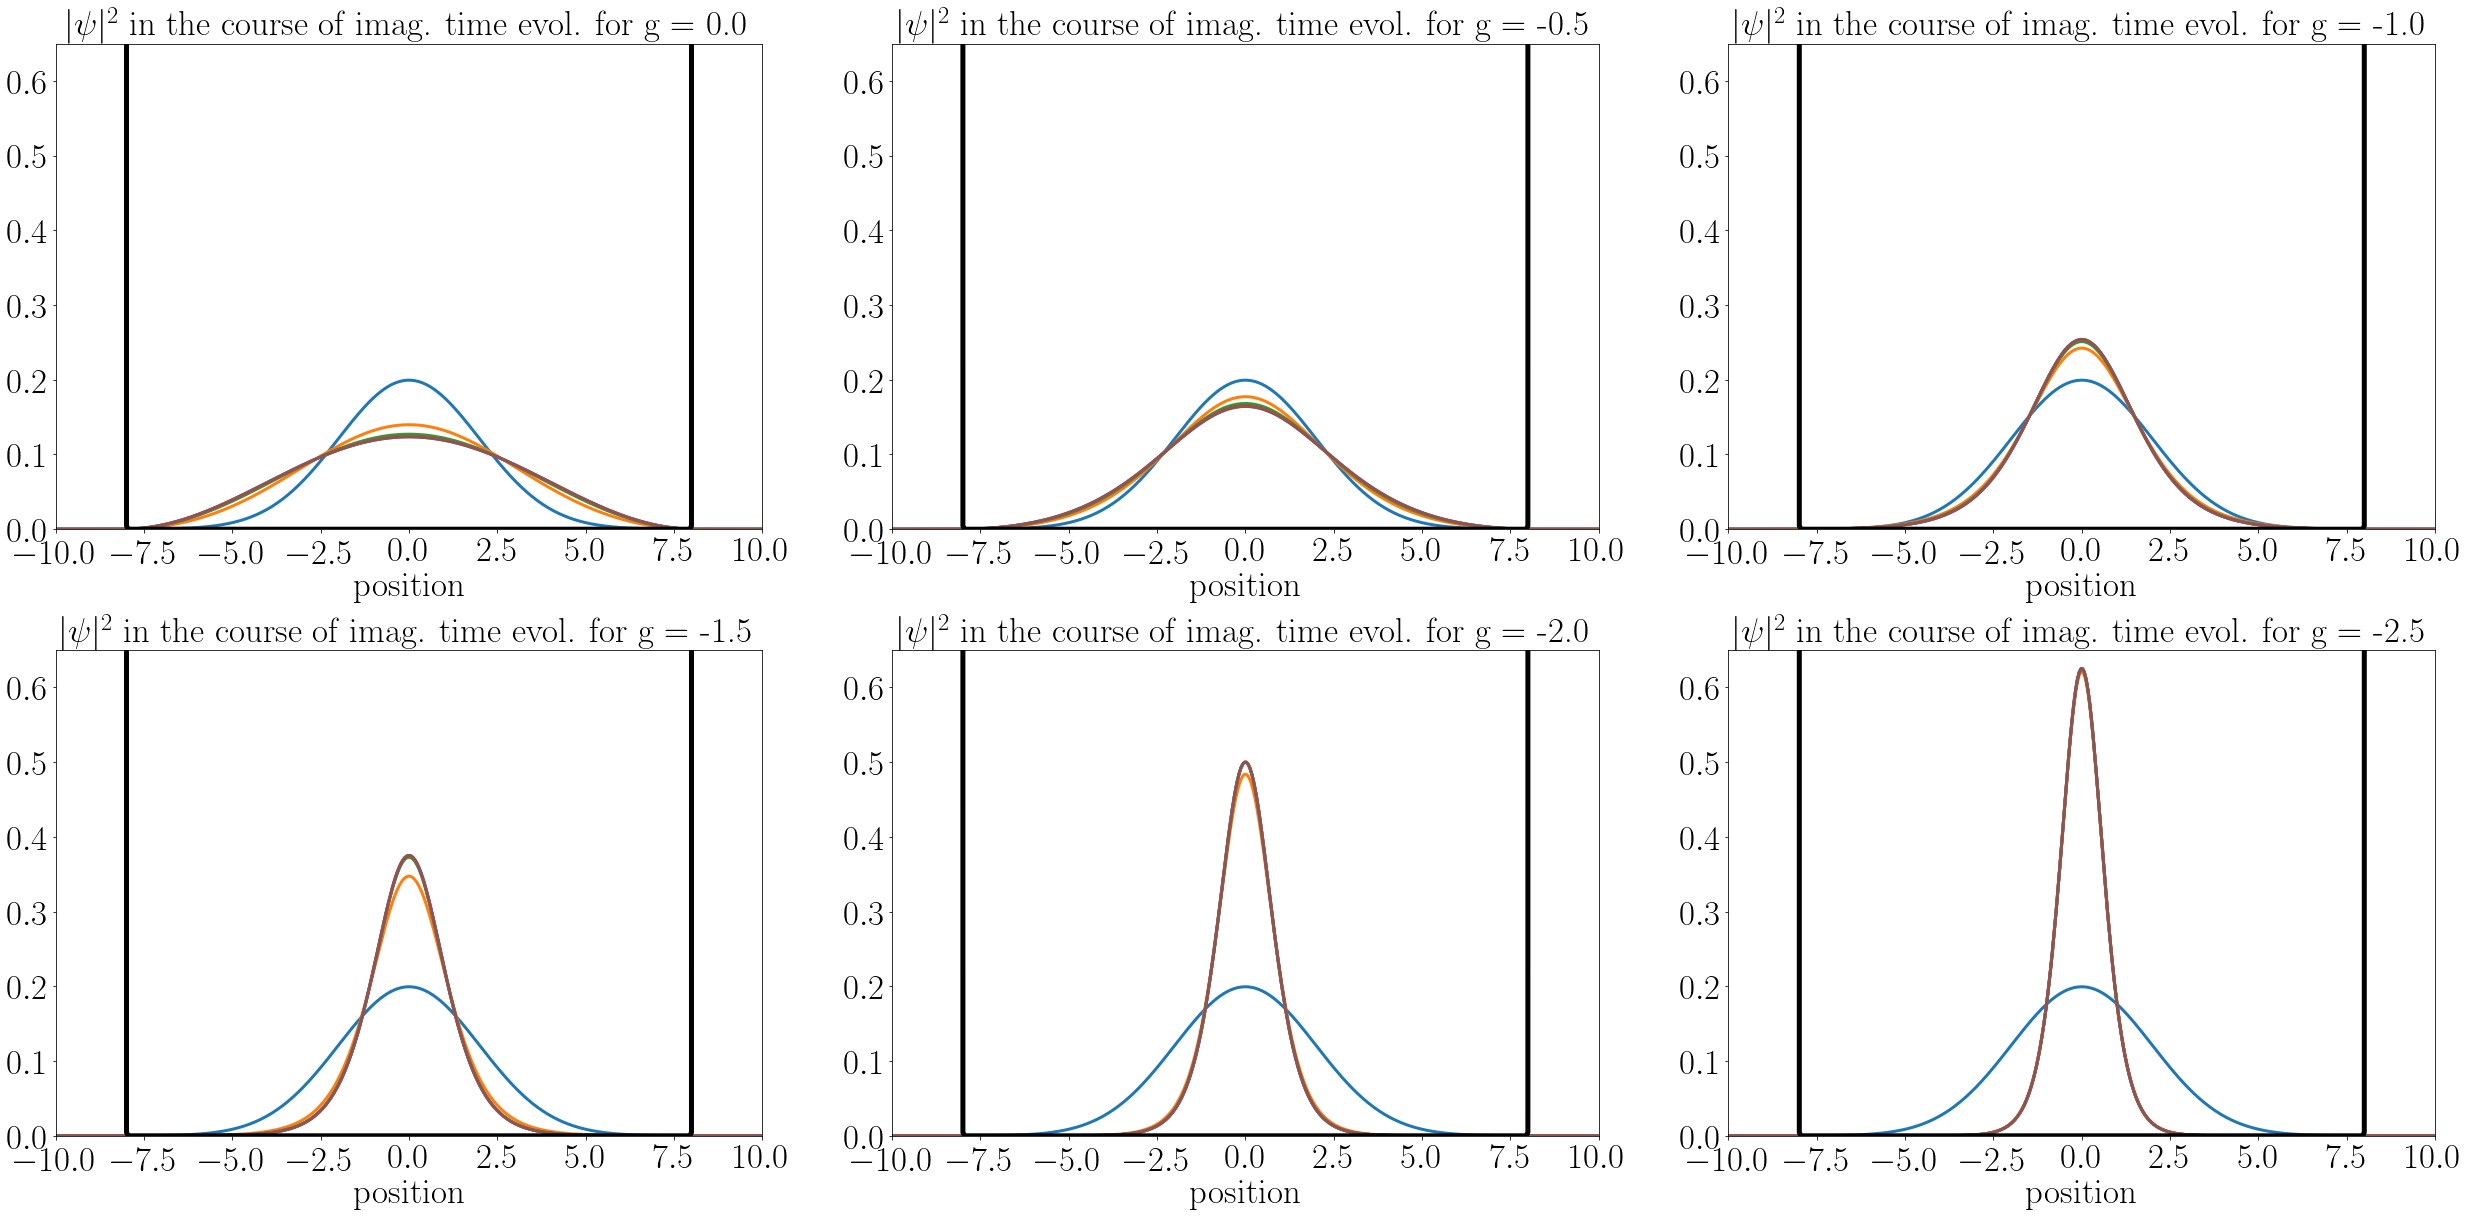

In [13]:
for q in range(0,Nsaves+1):
    plt.subplot(2,3,q+1)
    W = Ws[q]
    plt.ylim((0,0.65));
    plt.xlim((-L/2,L/2));
    for a in range(Nsaves+1):
        Y = np.absolute( W[0][a] )**2
        plt.plot(X,Y, linewidth=3)
        plt.xlabel("position",size=35);
        plt.xticks(size=35);
        plt.yticks(size=35);
        plt.title(r"$|\psi|^2$"+" in the course of imag. time evol. for g = " + str( Tab_g[q] ),fontsize=35);
    plt.plot(X,vecV,color='black',linewidth=5);
    fig = mpl.pyplot.gcf()
    fig.set_size_inches(35, 17)
plt.tight_layout()

We clearly see the localization of a bright soliton that is the narrower the more negative $g$ is considered. Let us focus on the intermediate ($g=-1.5$) and narrow soliton ($g=-2.5$) cases, set both states in motion with the same velocity and monitor their dynamics:

evolution of psi1
time = 0.0375 , energy = (12.33801823+0j) , norm = 1.0
time = 1.5375 , energy = (12.33801845-0j) , norm = 1.0
time = 3.0375 , energy = (12.33801825+0j) , norm = 1.0
time = 4.5375 , energy = (12.33801827-0j) , norm = 1.0
time = 6.0375 , energy = (12.33801827-0j) , norm = 1.0
time = 7.5375 , energy = (12.33801827-0j) , norm = 1.0
time = 9.0375 , energy = (12.33801827+0j) , norm = 1.0
time = 10.5375 , energy = (12.33801826-0j) , norm = 1.0
time = 12.0375 , energy = (12.33801825+0j) , norm = 1.0
time = 13.5375 , energy = (12.33801824-0j) , norm = 1.0
evolution of psi2
time = 0.0375 , energy = (12.16602537+0j) , norm = 1.0
time = 1.5375 , energy = (12.16602565+0j) , norm = 1.0
time = 3.0375 , energy = (12.16602548-0j) , norm = 1.0
time = 4.5375 , energy = (12.16602543-0j) , norm = 1.0
time = 6.0375 , energy = (12.16602538-0j) , norm = 1.0
time = 7.5375 , energy = (12.16602537-0j) , norm = 1.0
time = 9.0375 , energy = (12.16602539+0j) , norm = 1.0
time = 10.5375 , energy = 

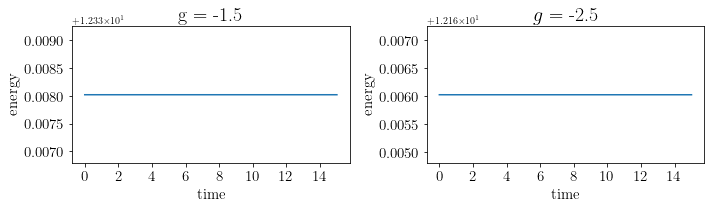

In [14]:
v = 5
psi1 = Ws[3][0][-1]*np.exp(1j*v*X)
psi2 = Ws[5][0][-1]*np.exp(1j*v*X)

dt = 0.0001
g1 = Tab_g[3]
g2 = Tab_g[5]

# generate matrices
IOp = InvOplus(vecV, dx, dt, b)
Om  = Ominus(vecV, dx, dt, b)

Nsteps = 375
Nsaves= 400

print("evolution of psi1")
S1 = evolution2(IOp, Om, Nsaves, Nsteps, psi1, vecV, dx, dt, g1, b)
print("evolution of psi2")
S2 = evolution2(IOp, Om, Nsaves, Nsteps, psi2, vecV, dx, dt, g2, b)

plt.subplot(1,2,1)
plt.plot(np.arange(0,Nsaves+1)*Nsteps*dt,np.real(S1[1]) ) 
plt.ylim( ( np.real(S1[1][0])*0.9999, np.real(S1[1][0])*1.0001 ) );
plt.ylabel("energy",size=15);
plt.xlabel("time",size=15);
plt.yticks(size=15);
plt.xticks(size=15);
plt.title("g = "+str(g1),size=20);
plt.subplot(1,2,2)
plt.plot(np.arange(0,Nsaves+1)*Nsteps*dt,np.real(S2[1]) ) 
plt.ylim( ( np.real(S2[1][0])*0.9999, np.real(S2[1][0])*1.0001 ) );
plt.ylabel("energy",size=15);
plt.xlabel("time",size=15);
plt.yticks(size=15);
plt.xticks(size=15);
plt.title(r"$g =$ "+str(g2),size=20);
fig = mpl.pyplot.gcf()
fig.set_size_inches(10, 3)
plt.tight_layout()

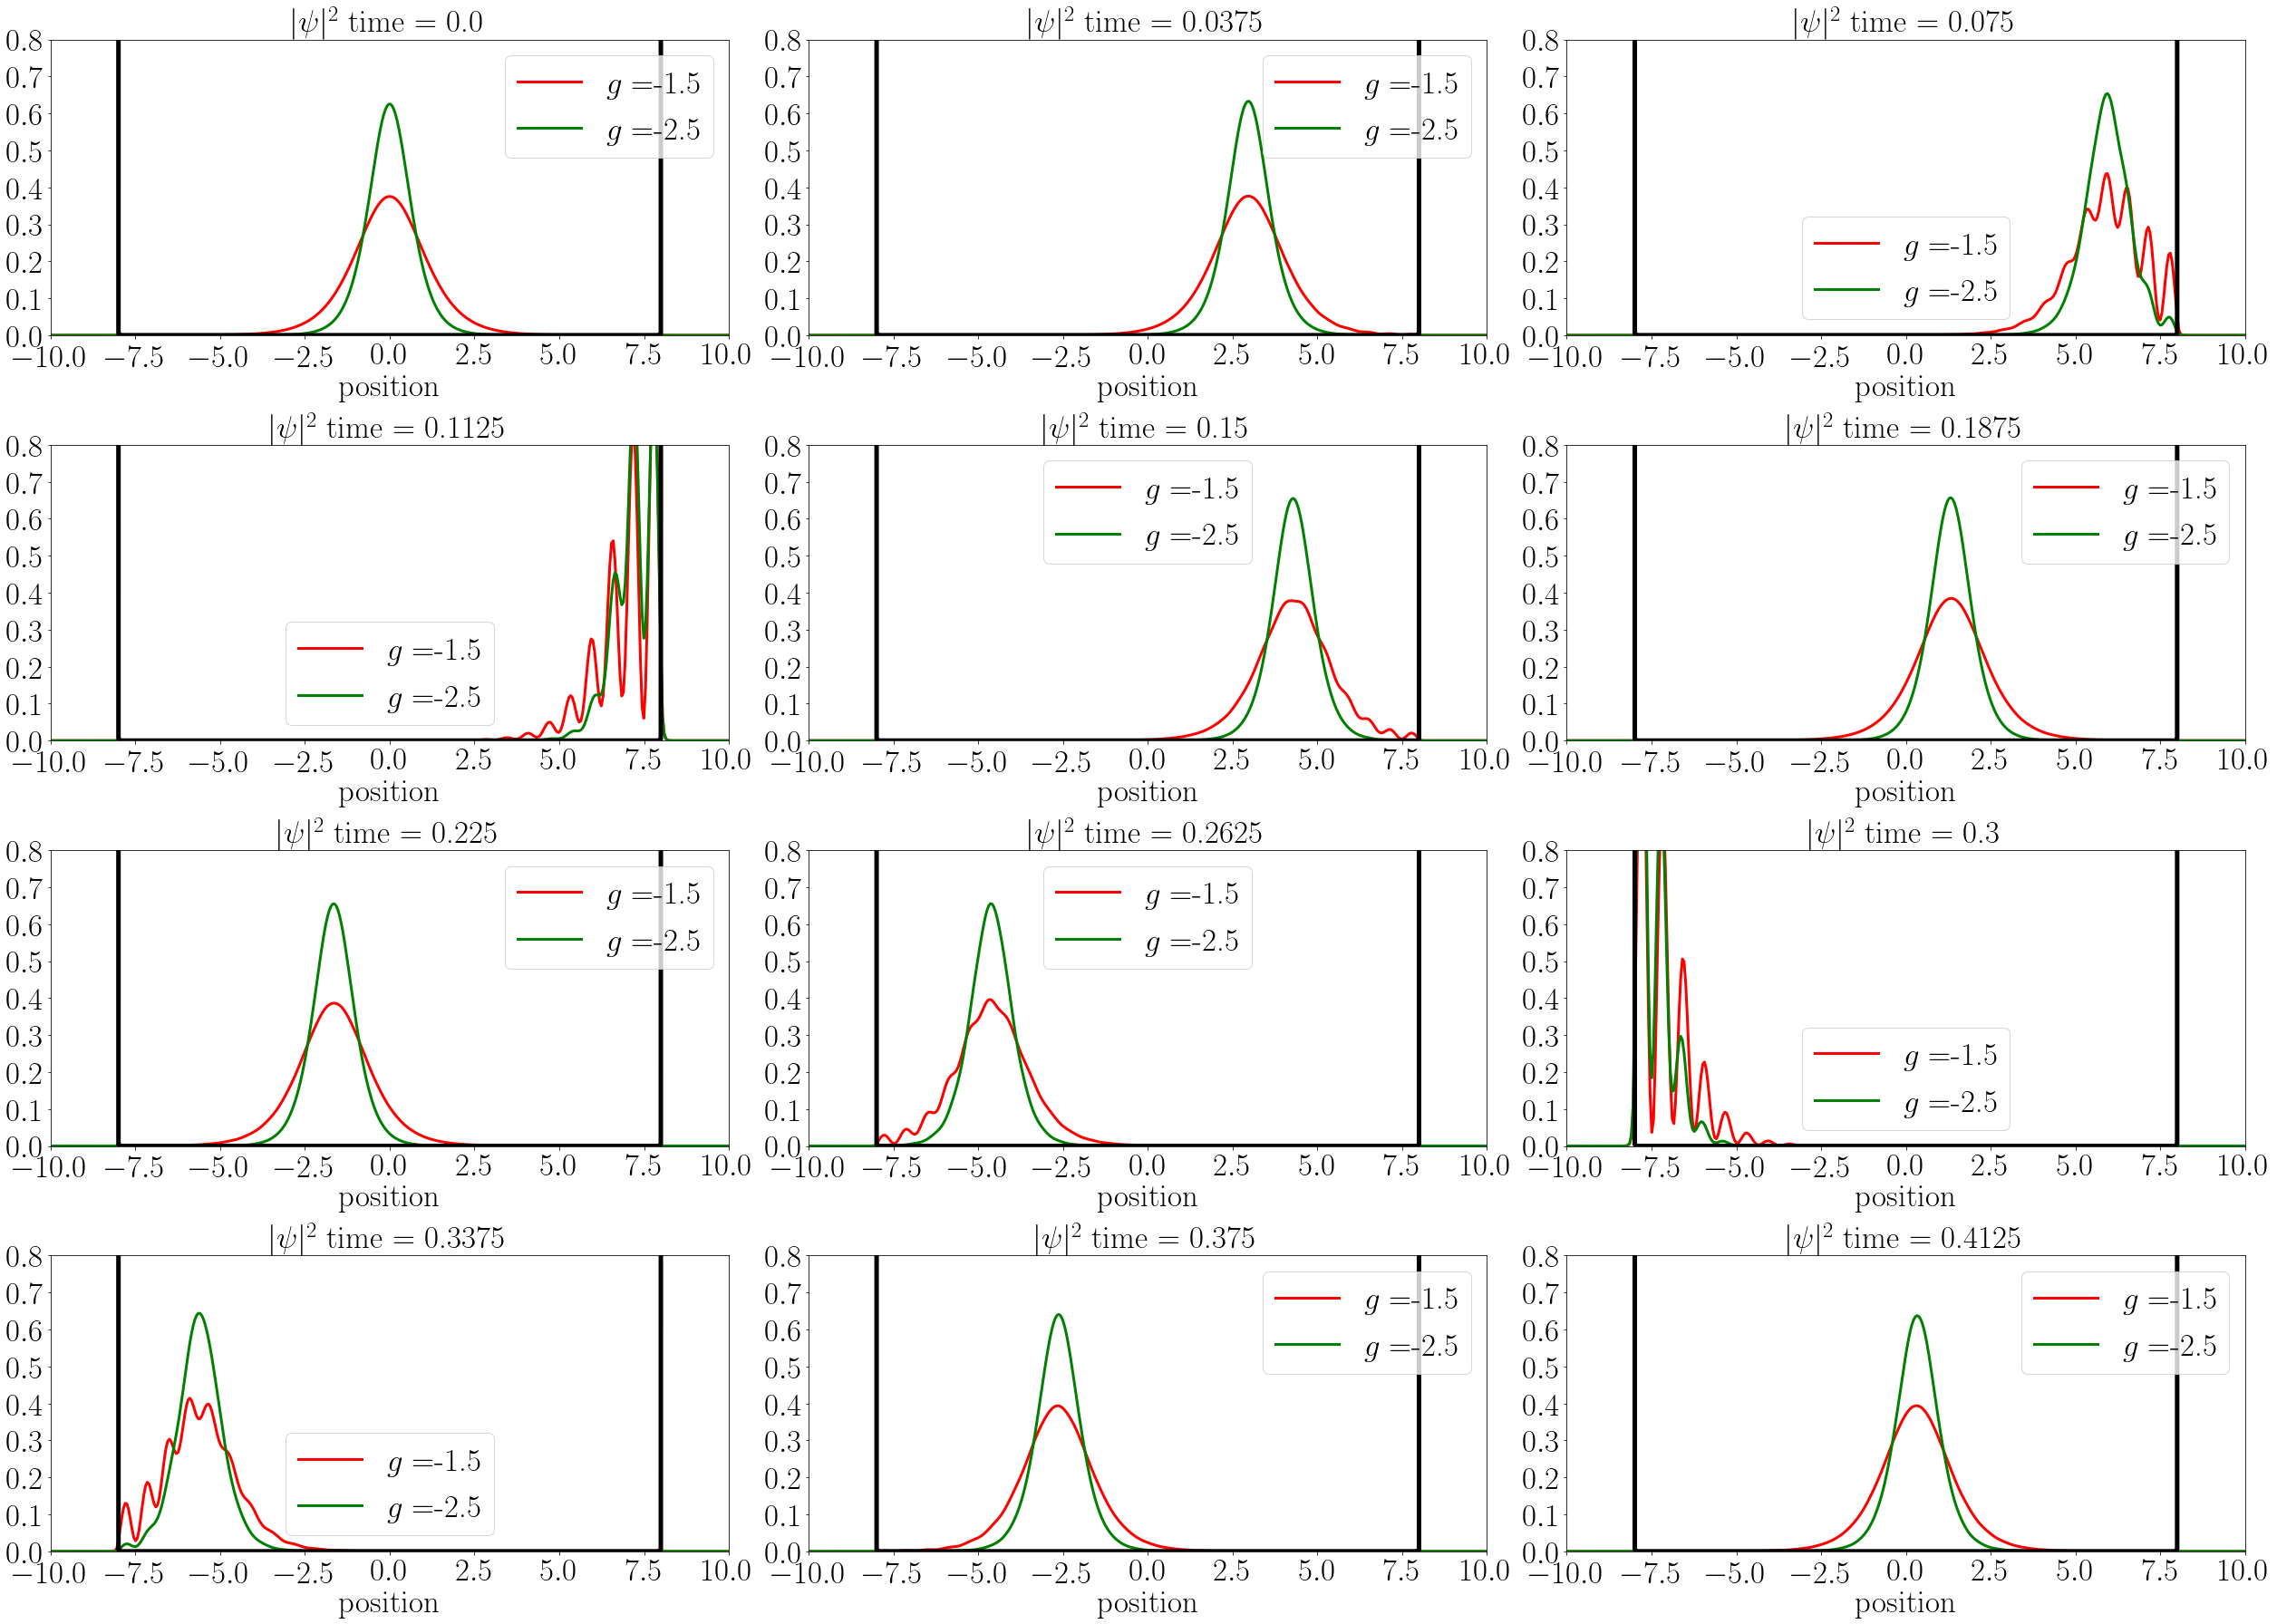

In [16]:
rr = int(len(S1[0])/24)
for q in range(0,12):
    plt.subplot(4,3,q+1)
    plt.ylim((0,0.8));
    plt.xlim((-L/2,L/2));
    Y1 = np.absolute( S1[0][rr*q] )**2
    Y2 = np.absolute( S2[0][rr*q] )**2
    plt.plot(X,Y1, color='red', linewidth=3)
    plt.plot(X,Y2, color='green', linewidth=3)
    plt.xlabel("position",size=35);
    plt.xticks(size=35);
    plt.yticks(size=35);
    plt.title(r"$|\psi|^2$"+" time = " + str( round( q*dt*Nsteps,4)),fontsize=35);
    plt.legend([r"$g = $"+str(g1),r"$g = $"+str(g2)],fontsize=35);
    plt.plot(X,vecV,color='black',linewidth=5);
    fig = mpl.pyplot.gcf()
    fig.set_size_inches(35, 25)
plt.tight_layout()

Note that the quadratic nonlinearity prevents the corresponding bright soliton probability density from spreading in time. The solitons bounce between walls revealing a particle-like behavior.

### Bright soliton propagation around the ring (PBC) with a narrow obstacle

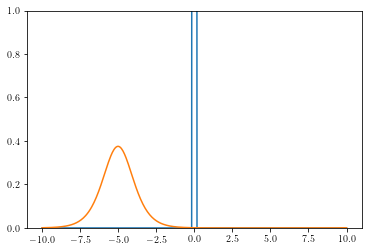

In [40]:
v = 5
psi = np.roll(Ws[3][0][-1]*np.exp(1j*v*X),-100)

# define potential of two high potential wells
vecV2 = 5*( (np.tanh((X+0.15)/0.001))-(np.tanh((X-0.15)/0.001)) )
plt.plot(X,vecV2)
plt.plot(X,np.absolute(psi)**2)
plt.ylim((0,1));

In [41]:
dt = 0.0001
g = Tab_g[3]
b=1 # periodic boundary conditions

# generate matrices
IOp = InvOplus(vecV2, dx, dt, b)
Om  = Ominus(vecV2, dx, dt, b)

Nsteps = 200
Nsaves= 400

Col = evolution2(IOp, Om, Nsaves, Nsteps, psi, vecV2, dx, dt, g, b)

time = 0.02 , energy = (12.34043106+0j) , norm = 1.0
time = 0.82 , energy = (12.34043109+0j) , norm = 1.0
time = 1.62 , energy = (12.34043101-0j) , norm = 1.0
time = 2.42 , energy = (12.34043099-0j) , norm = 1.0
time = 3.22 , energy = (12.34043103+0j) , norm = 1.0
time = 4.02 , energy = (12.34043093+0j) , norm = 1.0
time = 4.82 , energy = (12.34043095-0j) , norm = 1.0
time = 5.62 , energy = (12.34043088+0j) , norm = 1.0
time = 6.42 , energy = (12.34043085-0j) , norm = 1.0
time = 7.22 , energy = (12.3404309-0j) , norm = 1.0


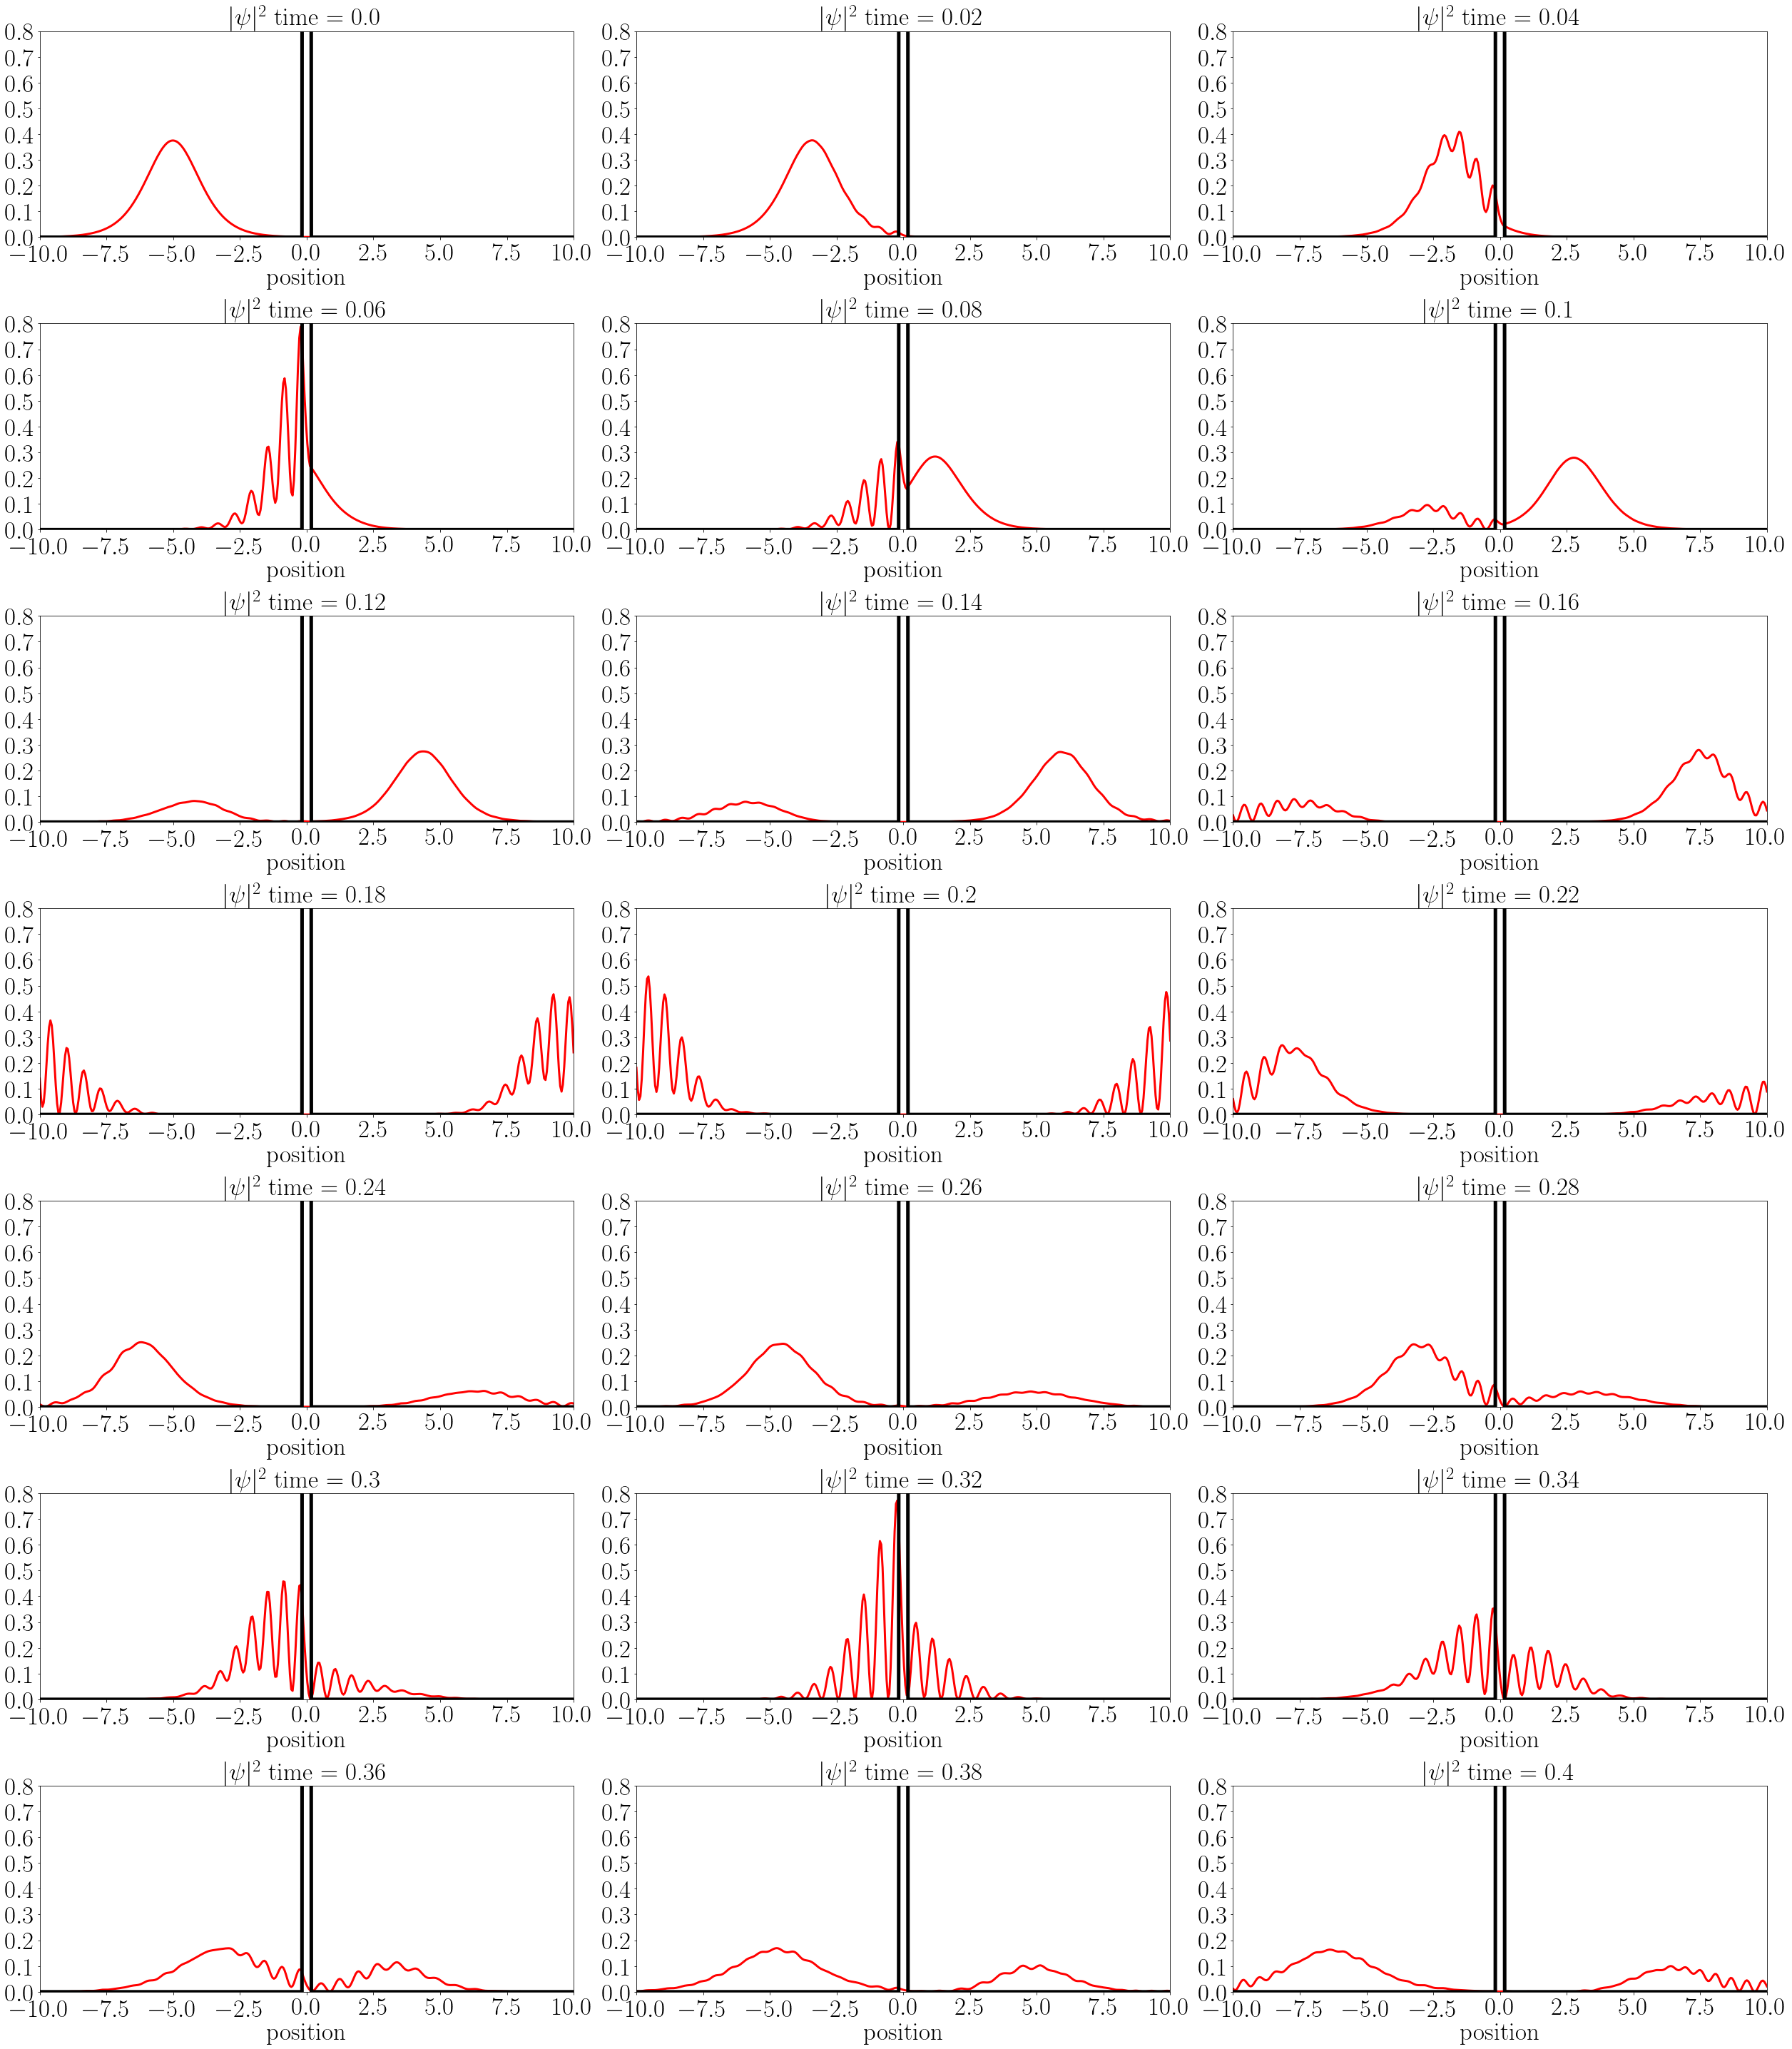

In [42]:
rr = int(len(Col[0])/24)
for q in range(0,21):
    plt.subplot(7,3,q+1)
    plt.ylim((0,0.8));
    plt.xlim((-L/2,L/2));
    Y = np.absolute( Col[0][rr*q] )**2
    plt.plot(X,Y, color='red', linewidth=3)
    plt.xlabel("position",size=35);
    plt.xticks(size=35);
    plt.yticks(size=35);
    plt.title(r"$|\psi|^2$"+" time = " + str( round( q*dt*Nsteps,4)),fontsize=35);
    plt.plot(X,vecV2,color='black',linewidth=5);

    fig = mpl.pyplot.gcf()
    fig.set_size_inches(35, 40)
plt.tight_layout()